In [1]:
import os  # for saving files
import numpy as np
from matplotlib import pyplot as plt
from juliacall import Main as jl
from muvi import geometry as geo


In [2]:
odir = 'vrtx_ring_fps'
if not os.path.exists(odir):
    os.makedirs(odir)

In [3]:
# Activate the Julia environment of the current
# directory.
jl.Pkg.activate('.')

# Run the Julia script to load the Biot-Savart
# function.
# jl.include('julia_src/biot_savart.jl')  # CPU version
jl.include('julia_src/biot_savart_cuda.jl')  # GPU version

def bs_solve(fps, vpps, vcrds, vcirs):
    # Call the Julia function.
    return np.transpose(jl.bs_solve(fps.T, vpps.T, vcrds, vcirs))

Max number of thread: 1024
Register usage: 61
Memory usage: (local = 208, shared = 0, constant = 0)


  Activating project at `~/Dropbox/code/vorpy`


In [4]:
#############################################
# Generate a vortex (points, core radii, and
# circulation).
#############################################

NUMSEGS = 100
VRADIUS = 1

# Generate the vortex points
# x = r * cos(theta)
# y = r * sin(theta)
theta = np.linspace(0, 2 * np.pi, NUMSEGS)
vpx = VRADIUS * np.cos(theta)
vpy = VRADIUS * np.sin(theta)
vpz = np.zeros_like(vpx)
vpps = np.concatenate([vpx[:, np.newaxis], vpy[:, np.newaxis], vpz[:, np.newaxis]], axis=1)
# To prevent numerical errors, explicitly set
# the last point to the the first.
vpps[-1] = vpps[0]

# Generate the core radii
vcrds = np.ones(NUMSEGS+1) * 1.0

# Generate the circulation
vcirs = np.ones(NUMSEGS+1) * 1.0

In [5]:
print('VRADIUS:', VRADIUS)
print('VRADIUS - 20%: ', VRADIUS * 0.8)
print('VRADIUS + 20%: ', VRADIUS * 1.2)
print('NUMSEGS:', NUMSEGS)
print('NUMSEGS - 20%: ', int(np.floor(NUMSEGS*0.8)))
print('NUMSEGS + 20%: ', int(np.ceil(NUMSEGS*1.2,)))
# np.floor(VRADIUS * 0.2)

VRADIUS: 1
VRADIUS - 20%:  0.8
VRADIUS + 20%:  1.2
NUMSEGS: 100
NUMSEGS - 20%:  80
NUMSEGS + 20%:  120


fps.shape: (8600, 3)


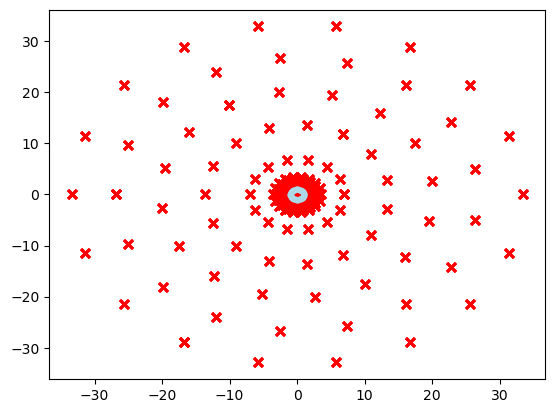

In [6]:
# NEED TO ADD Z COORDINATES
def cylin_mesh(r1, r2, rptsarray, zarray=[0]):
    # nsegarray: array with length rsteps which
    # specifies the number of segments for each
    # radius step.

    nrsteps = len(rptsarray)
    dr = (r2 - r1) / nrsteps

    cymx = []
    cymy = []

    for i in range(0, nrsteps):
        theta = np.linspace(0, 2 * np.pi, rptsarray[i])
        rad = (dr * i) + r1
        phase = (np.pi / 3) * i
        cymx.append(rad * np.cos(theta+phase))
        cymy.append(rad * np.sin(theta+phase))

    cymx = np.concatenate(cymx)
    stride = len(cymx)
    cymy = np.concatenate(cymy)

    nzsteps = len(zarray)
    cym = np.zeros((nzsteps * stride, 3))
    cym[:, 0] = np.tile(cymx, nzsteps)
    cym[:, 1] = np.tile(cymy, nzsteps)
    cym[:, 2] = np.repeat(zarray, stride)

    return cym

# rpts = np.arange(15, 20)
# fps = [cylin_mesh(7, 40, rpts)]
fps = [cylin_mesh(0.1, 0.6, np.arange(4, 7), np.linspace(-1, 1, 20)),  # center of ring
       cylin_mesh(0.7, 1.3, np.arange(20, 30), np.linspace(-2, 2, 20)),  # ring
       cylin_mesh(1.7, 4, np.arange(15, 20), np.linspace(-10, 10, 20)),  # outside of ring (near)
       cylin_mesh(7, 40, np.arange(15, 20), np.linspace(-40, 40, 20))]  # outside of ring (far)

fps = np.concatenate(fps, axis=0)
print('fps.shape:', fps.shape)

plt.scatter(fps[:, 0], fps[:, 1], marker='x', c='r', label='fps')
plt.plot(vpx, vpy, '.-', color='lightblue')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.show()


In [7]:
vel_num = bs_solve(fps, vpps, vcrds, vcirs)

In [8]:
np.concatenate([fps, vel_num], axis=1).tofile('vrtx_ring_fps/vel_num.csv', sep=',')

In [9]:
fieldpoints = geo.Points(
    fps,
    vel=vel_num,
    display=dict(),
    metadata=dict()
)

fieldpoints.save(os.path.join(odir, 'fieldpoints.vtp'))

In [10]:
# def fps_gen(radius, numsegs):
#     fpsx = []
#     fpsy = []
#     # numsegs = 50
#     # radius = .65
#     for i in range(1, 10):
#         numfps1 = int(np.ceil(numsegs * (0.7 + i * 0.1)))
#         theta = np.linspace(0, 2 * np.pi, numfps1)
#         fpsx.append(radius * (1 + i * 0.1) * np.cos(theta))
#         fpsy.append(radius * (1 + i * 0.1) * np.sin(theta))

#     fpsx = np.concatenate(fpsx)
#     stride = len(fpsx)
#     fpsy = np.concatenate(fpsy)

#     fps = np.zeros((3 * stride, 3))
#     fps[:, 0] = np.tile(fpsx, 3)
#     fps[:, 1] = np.tile(fpsy, 3)

#     # z = np.linspace(-1, 1, 3)
#     # for i in range(len(z)-1):
#     #     fps1[stride*i:stride*(i+1), 2] = z[i]

#     return fps

# fps1 = fps_gen(0.65, 10)

# plt.scatter(fps1[:, 0], fps1[:, 1], marker='x', c='r', label='fps1')
# plt.plot(vpx, vpy, '.-', color='lightblue')
# plt.show()

In [11]:
# vel_num = bs_solve(fps, vpps, vcrds, vcirs)
# ax = plt.figure().add_subplot(projection='3d')
# ax.quiver(fps[:, 0], fps[:, 1], fps[:, 2], vel_num[:, 0], vel_num[:, 1], vel_num[:, 2], length=0.02, normalize=True, linewidth=0.5)
# ax.view_init(80, 30)
# plt.show()

In [12]:
# # # Generate the field points
# # x = np.linspace(-2, 2, NUMFP)
# # y = np.linspace(-2, 2, NUMFP)
# # # z = np.linspace(-2, 2, NUMFP)
# # # z = np.zeros_like(x)
# # z = np.array([0])
# # mgx, mgy, mgz = np.meshgrid(x, y, z)
# # fps = np.concatenate([mgx.flatten()[:, np.newaxis], mgy.flatten()[:, np.newaxis], mgz.flatten()[:, np.newaxis]], axis=1)
# # print('Shape of fps:', fps.shape)
# # # plt.scatter(fps[:, 0], fps[:, 1], marker='x', color='r')
# # # plt.show()


# # plt.imshow(vel_num[:, 2].reshape(NUMFP, NUMFP))
# levels = np.linspace(np.min(vel_num[:, 2]), np.max(vel_num[:, 2]), 7)
# plt.contourf(fps[:, 0], fps[:, 1], vel_num[:, 2], levels=levels, cmap='magma')
# plt.colorbar()
# plt.plot(vpx, vpy, '.-', color='lightblue')
# # plt.scatter(fps[:, 0], fps[:, 1], marker='x', color='r')
# plt.show()